In [14]:
# !wget https://dysk.agh.edu.pl/s/G6ZNziBRbEEcMeN/download/Bike-Sharing-Dataset.zip -O Bike-Sharing-Dataset.zip
# !unzip Bike-Sharing-Dataset.zip
# !cat Readme.txt

In [15]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("BikerRental").master("local[*]").getOrCreate()
df = spark.read.csv('day.csv', header=True, inferSchema=True)
df.show(5)
df.printSchema()

+-------+----------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----+
|instant|    dteday|season| yr|mnth|holiday|weekday|workingday|weathersit|    temp|   atemp|     hum|windspeed|casual|registered| cnt|
+-------+----------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----+
|      1|2011-01-01|     1|  0|   1|      0|      6|         0|         2|0.344167|0.363625|0.805833| 0.160446|   331|       654| 985|
|      2|2011-01-02|     1|  0|   1|      0|      0|         0|         2|0.363478|0.353739|0.696087| 0.248539|   131|       670| 801|
|      3|2011-01-03|     1|  0|   1|      0|      1|         1|         1|0.196364|0.189405|0.437273| 0.248309|   120|      1229|1349|
|      4|2011-01-04|     1|  0|   1|      0|      2|         1|         1|     0.2|0.212122|0.590435| 0.160296|   108|      1454|1562|
|      5|2011-01-05|     1|  0|   1|      0|      3|   

In [16]:
if str(df.schema['dteday'].dataType) != 'DateType':
    df = df.withColumn("dteday", to_date(col("dteday"), "yyyy-MM-dd"))
    print("\\nSchema after date conversion:")
    df.printSchema()


\nSchema after date conversion:
root
 |-- instant: integer (nullable = true)
 |-- dteday: date (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)



In [17]:
pdf = df.toPandas()

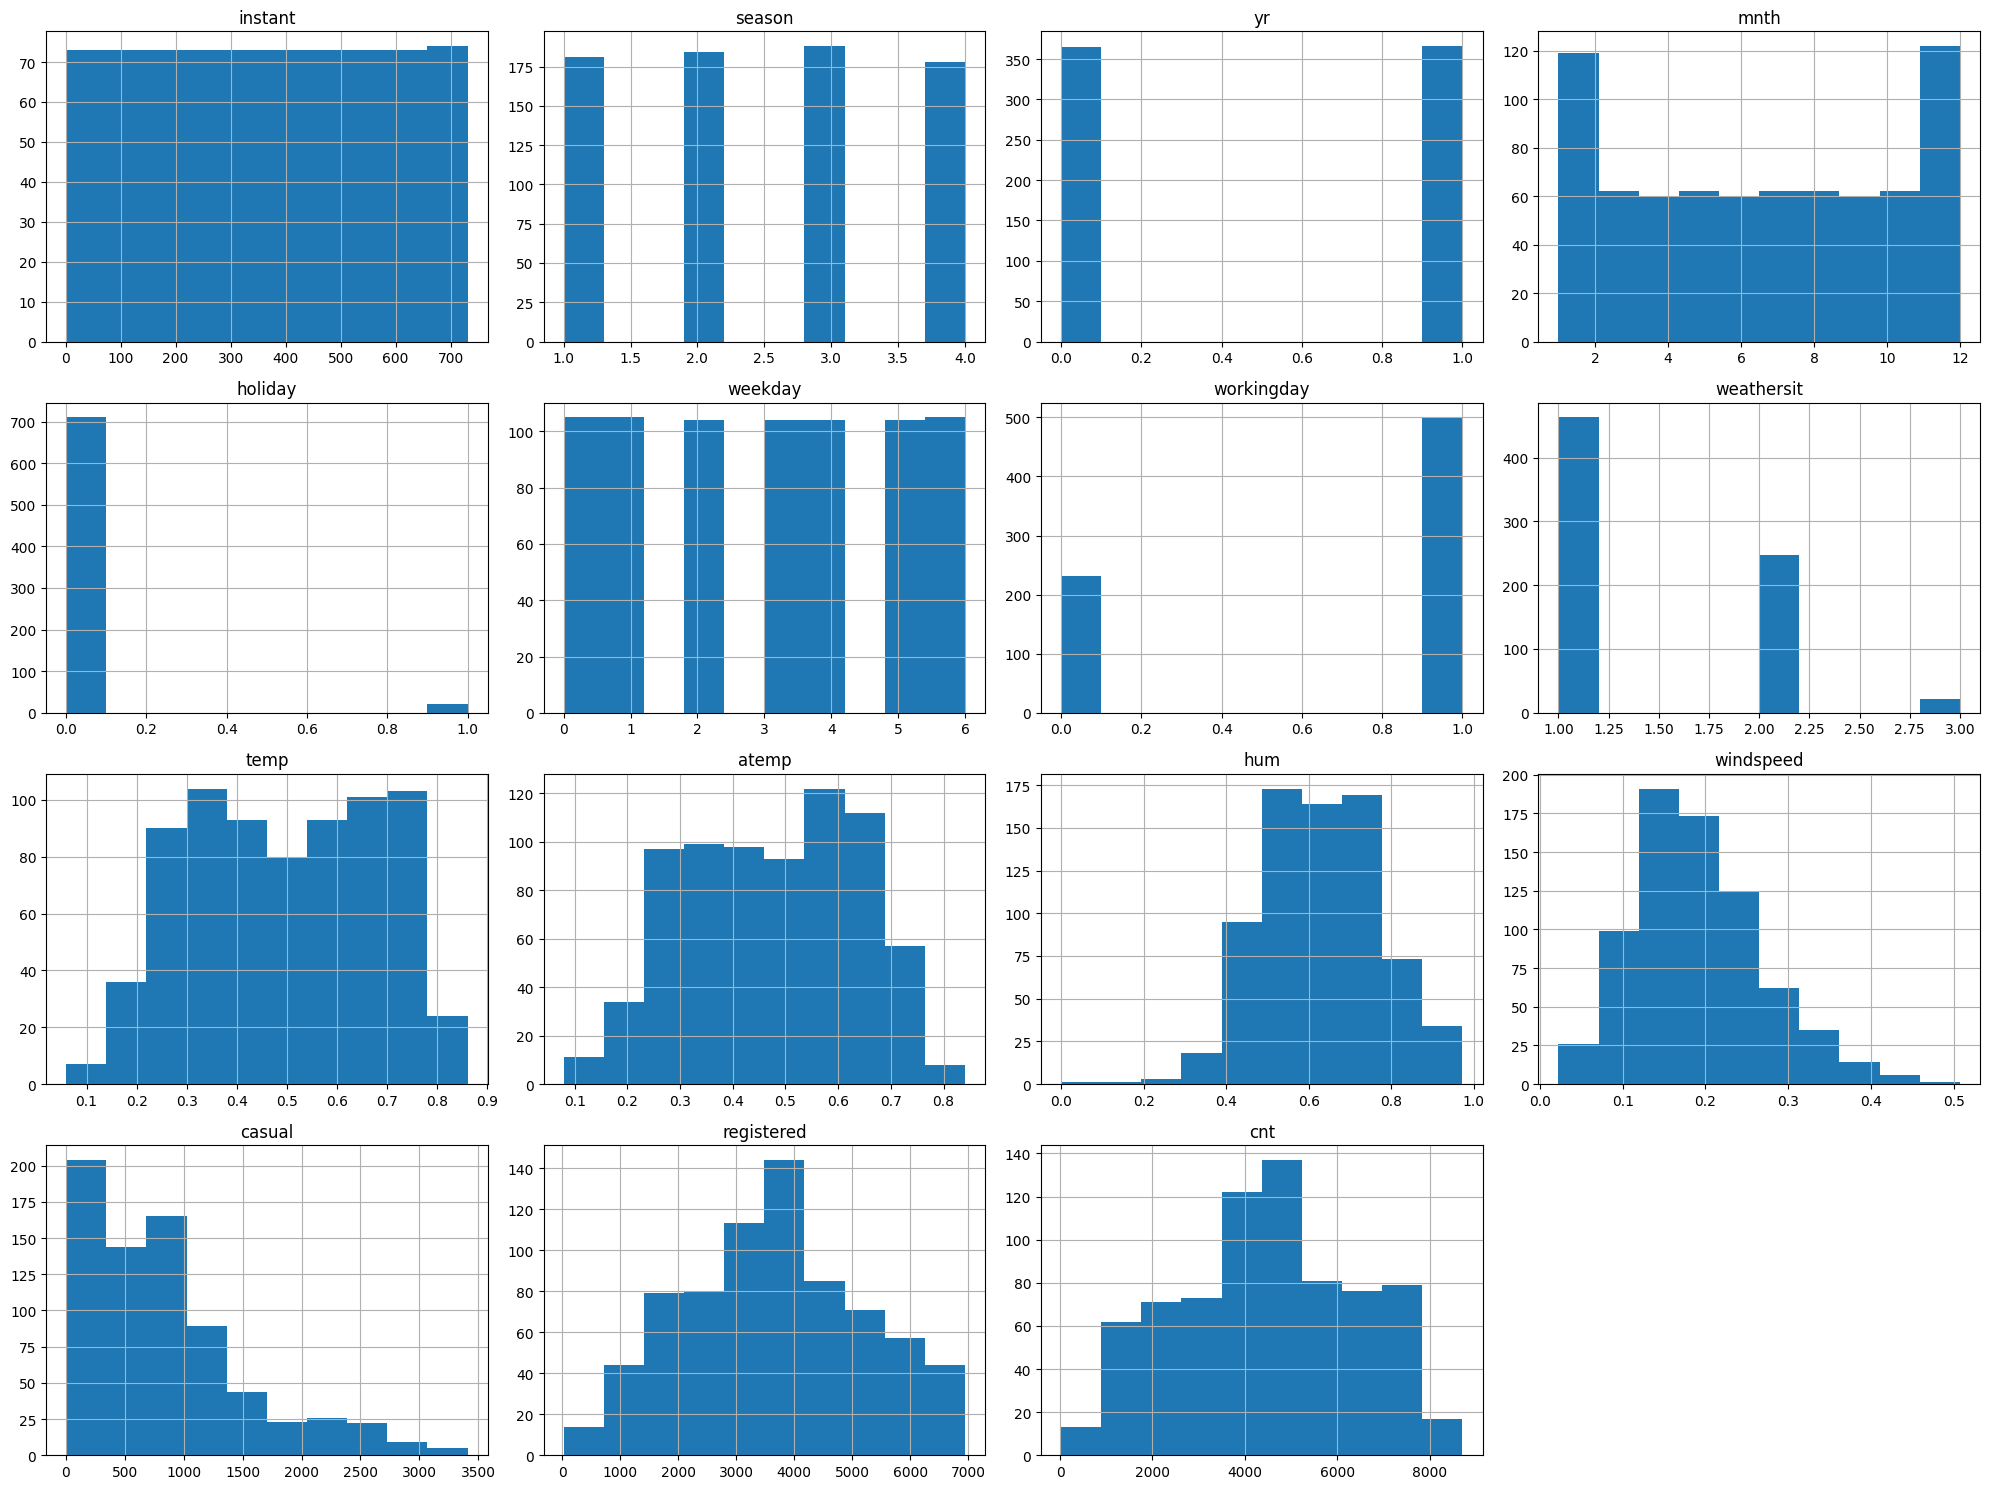

In [18]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 15)
pdf.hist()
plt.tight_layout()
plt.show()


\nPlotting counts over time:


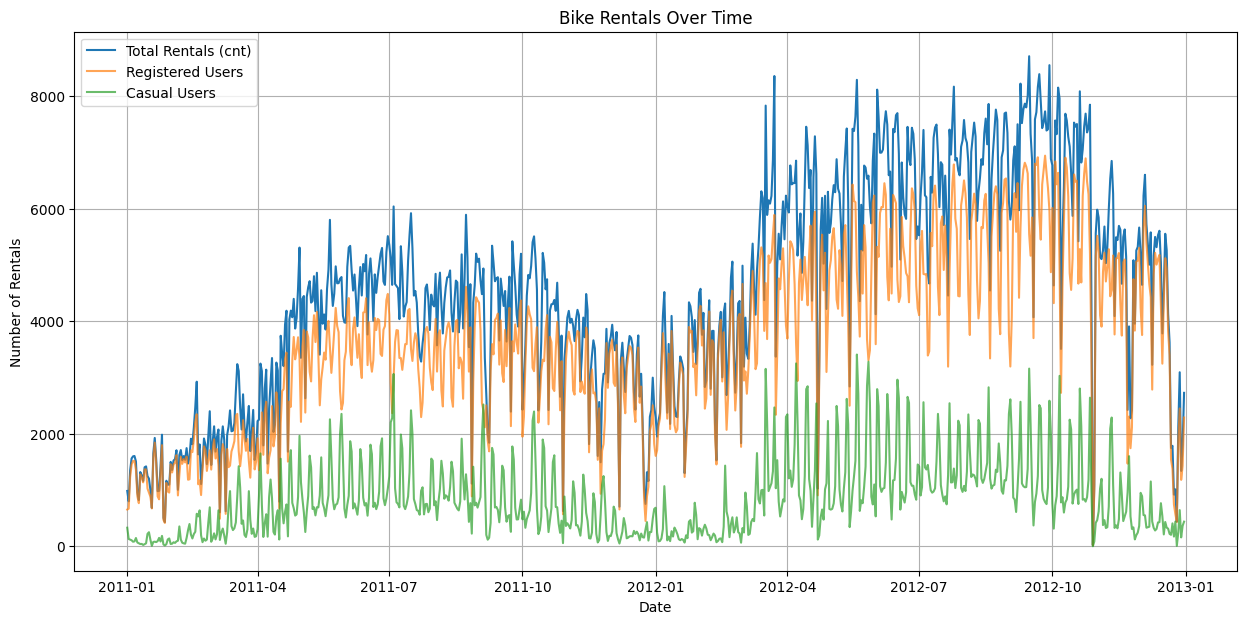

In [19]:
print("\\nPlotting counts over time:")
plt.figure(figsize=(15, 7))

pdf_sorted = pdf.sort_values(by='dteday')
plt.plot(pdf_sorted['dteday'], pdf_sorted['cnt'], label='Total Rentals (cnt)')
plt.plot(pdf_sorted['dteday'], pdf_sorted['registered'], label='Registered Users', alpha=0.7)
plt.plot(pdf_sorted['dteday'], pdf_sorted['casual'], label='Casual Users', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.title('Bike Rentals Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import unix_timestamp

def evaluate_metrics(df, metrics=['r2','rmse','mse','mae'], label_col='cnt', prediction_col='prediction'):
    """
    Funkcja oblicza metryki regresji na podstawie zbioru danych zawierającego prawdziwe wartosci etykiet
    i wartości przewidywane
    :param df: Dataset<Row> wejściowy zbiór danych
    :param metrics: lista metryk do obliczenia
    :param label_col: nazwa kolumny z wartościami wyjściowymi
    :param prediction_col: nazwa kolumny zawierającej przewidywane wartości
    :return: słownik zawierający pary (nazwa_metryki, wartość)
    """
    results = {}
    for metric in metrics:
        evaluator = RegressionEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName=metric)
        value = evaluator.evaluate(df)
        results[metric] = value
    return results

In [21]:
def train_and_test(df, feature_cols, label_col='cnt', lr=LinearRegression(maxIter=100, regParam=0.3, elasticNetParam=0.5)):
    """
    Funkcja (1) dzieli zbiór danych na df_train oraz df_test
    (2) tworzy ciąg przetwarzania zawierający VectorAssembler
    i  przekazaną jako parametr konfiguracje algorytmu regresji
    (3) buduje model i dokonuje predykcji dla df_train oraz df_test
    (4) wyświetla metryki
    :param df: wejściowy zbiór danych
    :param feature_cols: lista nazw kolumn cech
    :param label_col: nazwa kolumny docelowej
    :param lr: konfiguracja algorytmu regresji
    :return: model zwrócony przez pipeline.fit()
    """
    lr.setLabelCol(label_col)
    lr.setFeaturesCol("features")

    (df_train, df_test) = df.randomSplit([0.8, 0.2], seed=42) # Używamy seed dla powtarzalności

    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    pipeline = Pipeline(stages=[assembler, lr])

    print("Training the model...")
    model = pipeline.fit(df_train)

    print("Making predictions...")
    predictions_train = model.transform(df_train)
    predictions_test = model.transform(df_test)

    print("\nEvaluating on Training Data:")
    metrics_train = evaluate_metrics(predictions_train, label_col=label_col)
    print(f"Train: " + " ".join([f"{k}={v}" for k, v in metrics_train.items()]))

    print("\nEvaluating on Test Data:")
    metrics_test = evaluate_metrics(predictions_test, label_col=label_col)
    print(f"Test: " + " ".join([f"{k}={v}" for k, v in metrics_test.items()]))

    return model

In [22]:
df_regr = df.withColumn("unixdate", unix_timestamp(col("dteday"), "yyyy-MM-dd").cast("double"))

feature_cols = [c for c in df_regr.columns if c not in ['instant', 'dteday', 'casual', 'registered', 'cnt']]
print(f"\nFeature columns for regression: {feature_cols}")


Feature columns for regression: ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'unixdate']


In [23]:
trained_model = train_and_test(df=df_regr, feature_cols=feature_cols, label_col='cnt')

Training the model...
Making predictions...

Evaluating on Training Data:
Train: r2=0.7985861913321166 rmse=870.3795909223957 mse=757560.6322942368 mae=649.5815699383919

Evaluating on Test Data:
Test: r2=0.8023536968320716 rmse=845.5095168321028 mse=714886.3430536559 mae=638.2015318482119


In [24]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

(train_data, test_data) = df_regr.randomSplit([0.8, 0.2], seed=42)
print(f"CV Training set size: {train_data.count()}, CV Test set size: {test_data.count()}")
label_col = "cnt"

CV Training set size: 613, CV Test set size: 118


In [25]:
lr_cv = LinearRegression(labelCol=label_col, featuresCol="features")
assembler_cv = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

pipeline_cv = Pipeline(stages=[assembler_cv, lr_cv])

paramGrid = ParamGridBuilder() \
    .addGrid(lr_cv.regParam, [0.1, 0.5, 1.0, 2.0, 3.0]) \
    .addGrid(lr_cv.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
    .build()

evaluator_cv = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse") # Domyślnie RMSE

cv = CrossValidator(estimator=pipeline_cv,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_cv,
                    numFolds=5, 
                    seed=42,
                    parallelism=2) 


In [29]:
print("Starting Cross-Validation...")
cvModel = cv.fit(train_data) 
print("Cross-Validation finished.")

Starting Cross-Validation...
Cross-Validation finished.


In [27]:
bestPipelineModel = cvModel.bestModel
bestLRModel = bestPipelineModel.stages[-1]

print("\nBest model parameters found by CV:")
print("regParam:", bestLRModel.getRegParam())
print("elasticNetParam:", bestLRModel.getElasticNetParam())

print("\nEvaluating the best model on the test set:")
predictions_test_cv = bestPipelineModel.transform(test_data)
test_metrics_cv = evaluate_metrics(predictions_test_cv, label_col=label_col, prediction_col="prediction")
print(f"Test CV: " + " ".join([f"{k}={v}" for k, v in test_metrics_cv.items()]))


Best model parameters found by CV:
regParam: 1.0
elasticNetParam: 0.75

Evaluating the best model on the test set:
Test CV: r2=0.798886238602003 rmse=852.8939755830152 mse=727428.1335858009 mae=650.6836987372918


In [30]:
def plot(df, model, label_col='cnt', prediction_col='prediction', start=0, end=-1):
    """
    Wyświetla wykres wartości rzeczywistych i przewidywanych dla modelu regresji.
    :param df: DataFrame zawierający dane do predykcji i wartości rzeczywiste.
    :param model: Wytrenowany model (PipelineModel lub model regresji).
    :param label_col: Nazwa kolumny z wartościami rzeczywistymi.
    :param prediction_col: Nazwa kolumny z wartościami przewidywanymi (po transformacji).
    :param start: Indeks początkowy zakresu do wyświetlenia.
    :param end: Indeks końcowy zakresu do wyświetlenia (-1 oznacza do końca).
    """
    count = df.count()
    if start < 0:
        start = 0
    if end == -1 or end > count:
        end = count
    if start >= end:
        print("Error: start index must be less than end index.")
        return

    print(f"Plotting results from index {start} to {end-1}")

    df_pred = model.transform(df)


    y_all = df_pred.select(label_col).rdd.flatMap(lambda r: r).collect()
    y_pred_all = df_pred.select(prediction_col).rdd.flatMap(lambda r: r).collect()

    if len(y_all) != len(y_pred_all):
         print(f"Warning: Length mismatch after collecting data: y={len(y_all)}, y_pred={len(y_pred_all)}")
         min_len = min(len(y_all), len(y_pred_all))
         y_all = y_all[:min_len]
         y_pred_all = y_pred_all[:min_len]
         if end > min_len: end = min_len
         if start >= end:
             print("Error: start index exceeds available data length after potential mismatch adjustments.")
             return


    y_range = y_all[start:end]
    y_pred_range = y_pred_all[start:end]
    x = np.arange(start, end) 

    plt.figure(figsize=(15, 6))
    plt.plot(x, y_range, label=f'True ({label_col})')
    plt.plot(x, y_pred_range, label=f'Predicted ({prediction_col})', alpha=0.7)
    plt.legend()
    try:
        model_name = model.stages[-1].__class__.__name__
    except AttributeError: 
        model_name = model.__class__.__name__
    plt.title(f'{model_name} - True vs Predicted (Indices {start}-{end-1})')
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

Plotting results from index 0 to 49


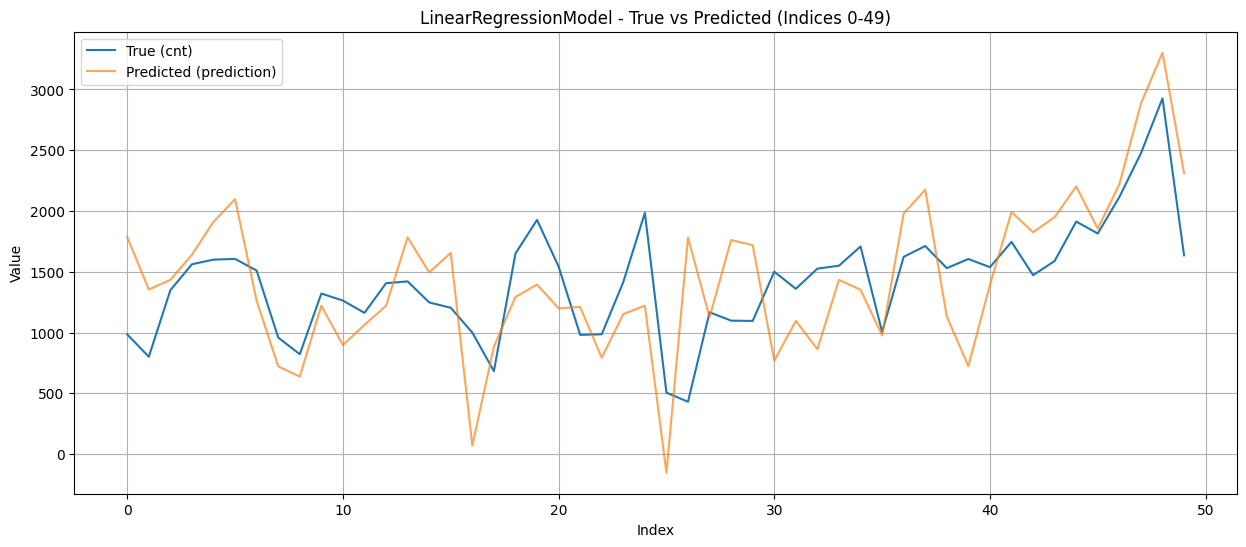

Plotting results from index 100 to 149


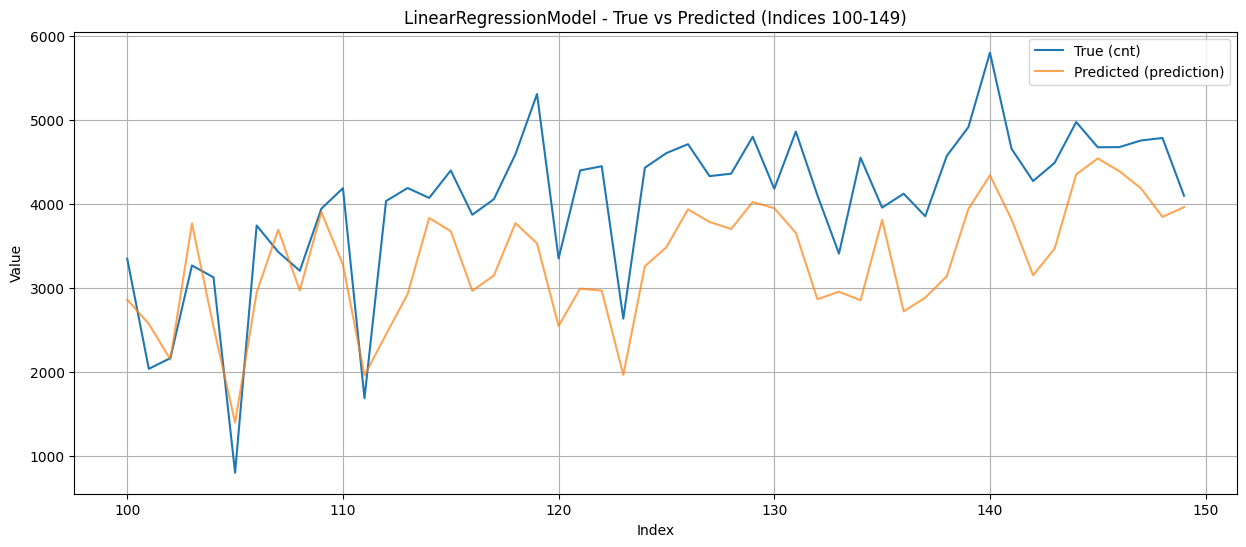

Plotting results from index 0 to 730


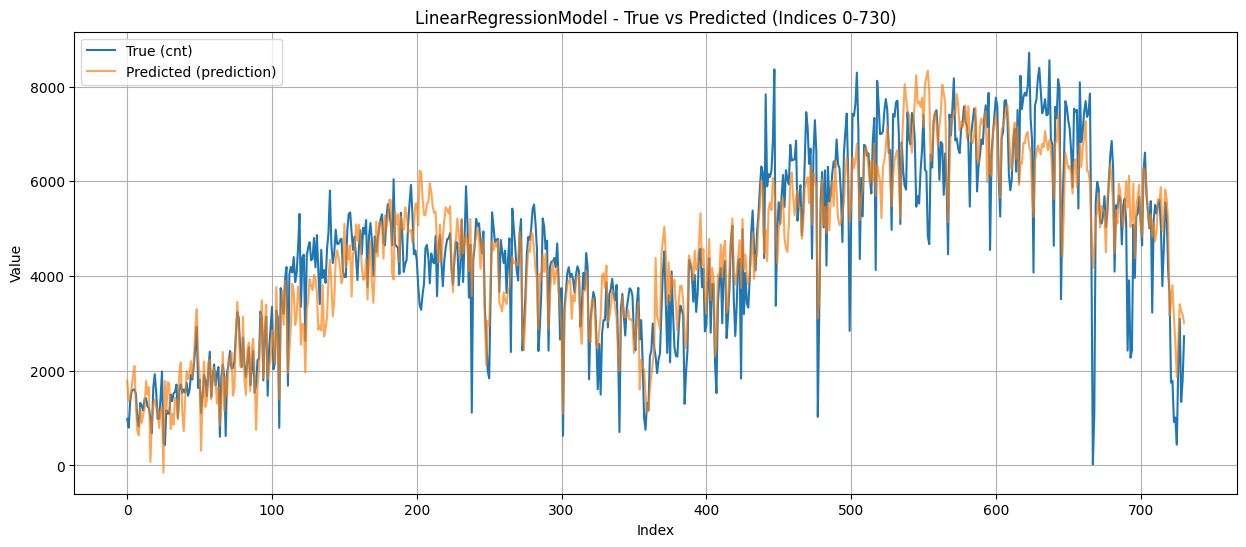

In [31]:
plot(df=df_regr, model=bestPipelineModel, start=0, end=50) # Pierwsze 50 punktów
plot(df=df_regr, model=bestPipelineModel, start=100, end=150) # Zakres w środku
plot(df=df_regr, model=bestPipelineModel) # Cały zbiór (może być nieczytelny)

In [32]:
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, GBTRegressor

best_lr = LinearRegression(
    maxIter=100, 
    regParam=bestLRModel.getRegParam(),
    elasticNetParam=bestLRModel.getElasticNetParam(),
    labelCol=label_col,
    featuresCol="features"
)

dt = DecisionTreeRegressor(labelCol=label_col, featuresCol="features")
rf = RandomForestRegressor(labelCol=label_col, featuresCol="features", seed=42)
gbt = GBTRegressor(labelCol=label_col, featuresCol="features", seed=42)

regressors = [best_lr, dt, rf, gbt]

results = {}
trained_models = {}

print("Defined regressors to compare:", [r.__class__.__name__ for r in regressors])

Defined regressors to compare: ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GBTRegressor']


In [35]:
assembler_comp = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

for regressor in regressors:
    model_name = regressor.__class__.__name__
    print(f"\n--- Training and Evaluating {model_name} ---")

    pipeline = Pipeline(stages=[assembler_comp, regressor])

    try:
        model = pipeline.fit(train_data)
        print(f"Finished training {model_name}.")

        print(f"Making predictions with {model_name} on test data...")
        predictions = model.transform(test_data)

        prediction_col_name = regressor.getPredictionCol()
        metrics = evaluate_metrics(predictions, label_col=label_col, prediction_col=prediction_col_name)
        print(f"Test Metrics ({model_name}): " + " ".join([f"\n{k}={v}" for k, v in metrics.items()]))

        results[model_name] = metrics
        trained_models[model_name] = model 

    except Exception as e:
        print(f"ERROR training/evaluating {model_name}: {e}")
        results[model_name] = None 
        trained_models[model_name] = None


--- Training and Evaluating LinearRegression ---
Finished training LinearRegression.
Making predictions with LinearRegression on test data...
Test Metrics (LinearRegression): 
r2=0.798886238602003 
rmse=852.8939755830152 
mse=727428.1335858009 
mae=650.6836987372918

--- Training and Evaluating DecisionTreeRegressor ---
Finished training DecisionTreeRegressor.
Making predictions with DecisionTreeRegressor on test data...
Test Metrics (DecisionTreeRegressor): 
r2=0.7569718750354462 
rmse=937.5672324992886 
mse=879032.315456375 
mae=634.2722057055026

--- Training and Evaluating RandomForestRegressor ---
Finished training RandomForestRegressor.
Making predictions with RandomForestRegressor on test data...
Test Metrics (RandomForestRegressor): 
r2=0.848587388928303 
rmse=740.0399700173717 
mse=547659.1572233124 
mae=539.6079381534458

--- Training and Evaluating GBTRegressor ---
Finished training GBTRegressor.
Making predictions with GBTRegressor on test data...
Test Metrics (GBTRegresso

In [39]:
best_r2 = -float('inf')
best_model_name = None
best_model_pipeline = None

for name, metrics in results.items():
    if metrics and 'r2' in metrics:
        print(f"Model: {name}, Test R2: {metrics['r2']}")
        if metrics['r2'] > best_r2:
            best_r2 = metrics['r2']
            best_model_name = name
            best_model_pipeline = trained_models[name] 
    elif name in trained_models: 
         print(f"Model: {name}, Evaluation failed or R2 not available.")

print(f"\nBest algorithm found: {best_model_name} (Test R2 = {best_r2})")

Model: LinearRegression, Test R2: 0.798886238602003
Model: DecisionTreeRegressor, Test R2: 0.7569718750354462
Model: RandomForestRegressor, Test R2: 0.848587388928303
Model: GBTRegressor, Test R2: 0.7613027898409288

Best algorithm found: RandomForestRegressor (Test R2 = 0.848587388928303)



--- Plotting results for the best model: RandomForestRegressor ---

Plotting first 100 points of the test set:
Plotting results from index 0 to 99


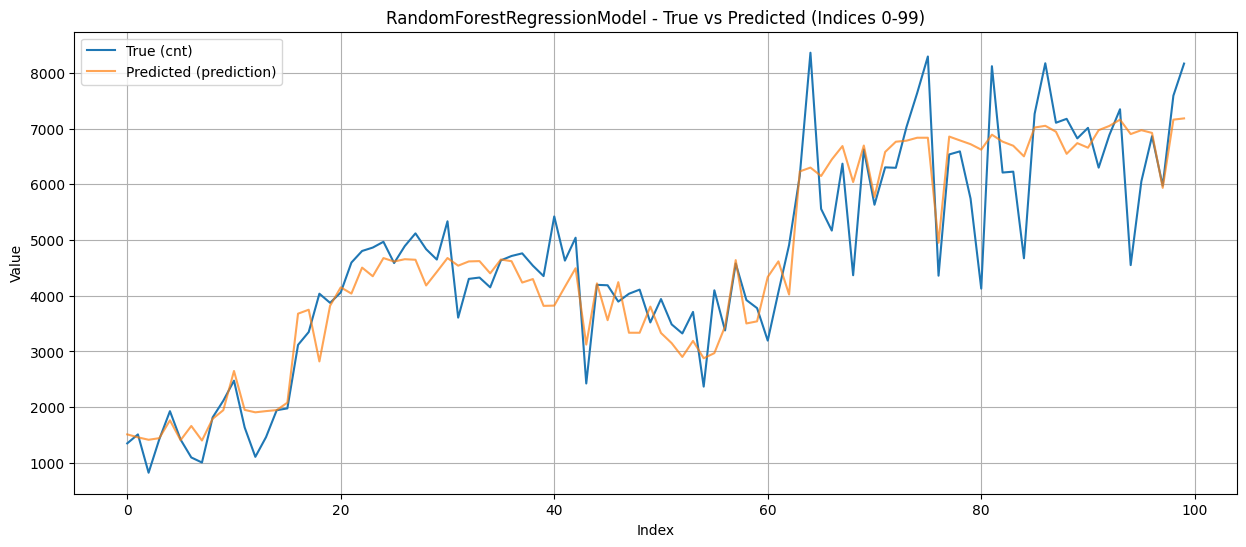


Plotting all points of the test set (may be slow/unclear):
Plotting results from index 0 to 117


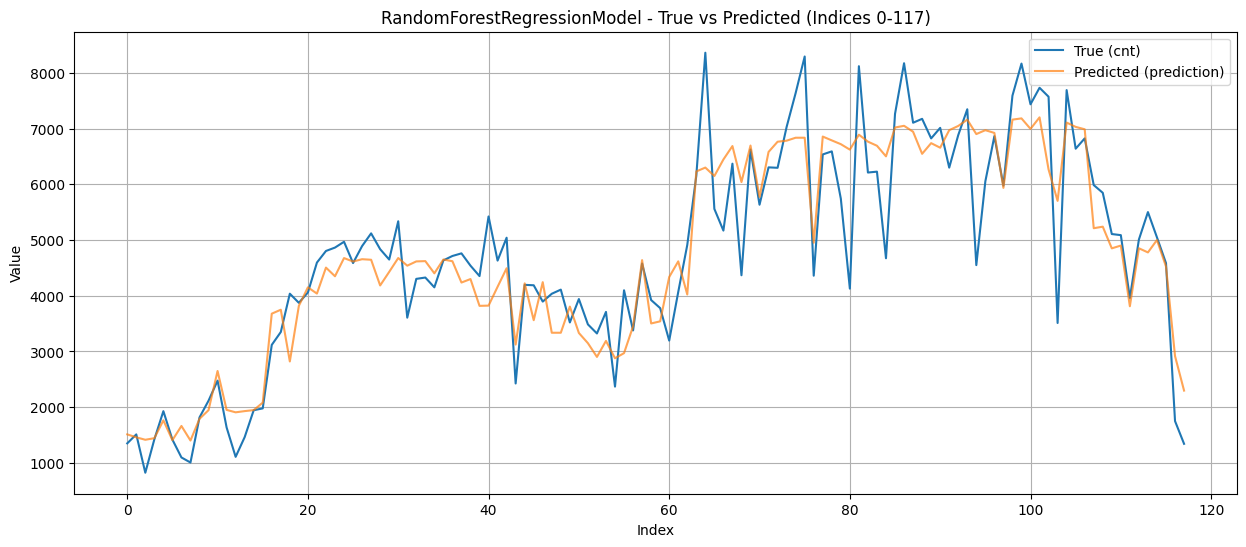

In [40]:
print(f"\n--- Plotting results for the best model: {best_model_name} ---")
try:
    best_regressor_stage = best_model_pipeline.stages[-1]
    prediction_col_name_best = best_regressor_stage.getPredictionCol()

    print("\nPlotting first 100 points of the test set:")
    plot(df=test_data, model=best_model_pipeline, label_col=label_col, prediction_col=prediction_col_name_best, start=0, end=100)

    print("\nPlotting all points of the test set (may be slow/unclear):")
    plot(df=test_data, model=best_model_pipeline, label_col=label_col, prediction_col=prediction_col_name_best)
except NameError:
    print("ERROR: The 'plot' function is not defined. Please ensure it was defined in a previous cell.")
except Exception as e:
        print(f"An error occurred during plotting: {e}")


In [42]:
print(f"\n--- Calculating Pearson Correlation with '{label_col}' ---")
correlations = {}
for col_name in feature_cols:
    col_type = df_regr .schema[col_name].dataType
    if isinstance(col_type, (pyspark.sql.types.NumericType, pyspark.sql.types.DoubleType, pyspark.sql.types.IntegerType, pyspark.sql.types.FloatType, pyspark.sql.types.LongType, pyspark.sql.types.ShortType, pyspark.sql.types.ByteType)):
            correlation = df_regr .stat.corr(col_name, label_col)
            correlations[col_name] = correlation
            print(f"Correlation between '{col_name}' and '{label_col}': {correlation:.4f}")
    else:
        print(f"Skipping correlation for non-numeric column '{col_name}' (Type: {col_type})")
        correlations[col_name] = None 
    


--- Calculating Pearson Correlation with 'cnt' ---
Correlation between 'season' and 'cnt': 0.4061
Correlation between 'yr' and 'cnt': 0.5667
Correlation between 'mnth' and 'cnt': 0.2800
Correlation between 'holiday' and 'cnt': -0.0683
Correlation between 'weekday' and 'cnt': 0.0674
Correlation between 'workingday' and 'cnt': 0.0612
Correlation between 'weathersit' and 'cnt': -0.2974
Correlation between 'temp' and 'cnt': 0.6275
Correlation between 'atemp' and 'cnt': 0.6311
Correlation between 'hum' and 'cnt': -0.1007
Correlation between 'windspeed' and 'cnt': -0.2345
Correlation between 'unixdate' and 'cnt': 0.6288



--- Generating Scatter Plots (using 30.0% sample) ---
Sample size for plotting: 232 rows


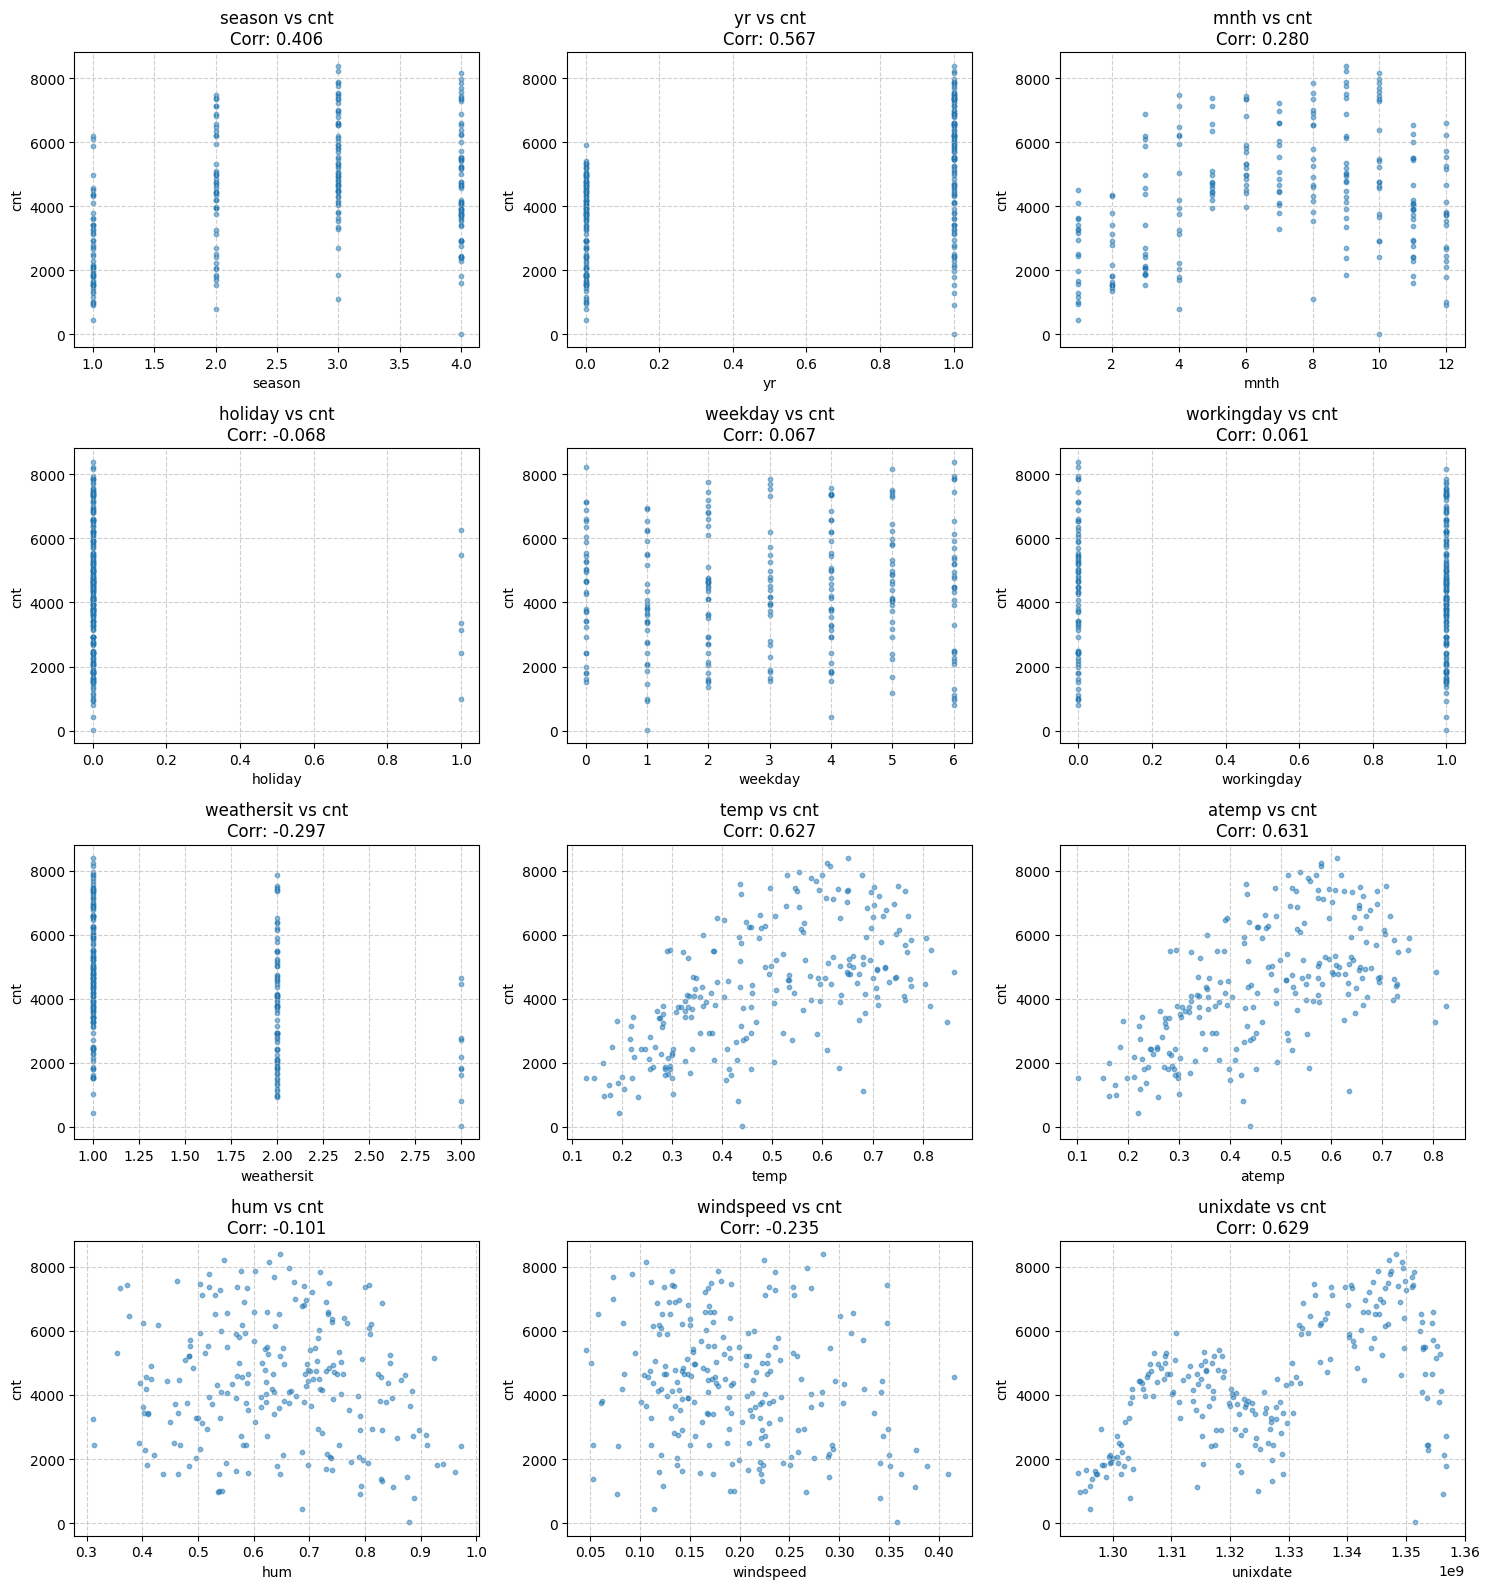

In [44]:
sample_fraction = 0.3
seed = 42
print(f"\n--- Generating Scatter Plots (using {sample_fraction*100}% sample) ---")

sample_pdf = df_regr .select(feature_cols + [label_col]).sample(fraction=sample_fraction, seed=seed).toPandas()
print(f"Sample size for plotting: {len(sample_pdf)} rows")

if sample_pdf.empty:
    print("WARN: Sampled DataFrame is empty. Cannot generate plots.")
else:
    num_features = len(feature_cols)
    cols_plot = 3 
    rows_plot = int(np.ceil(num_features / cols_plot))

    plt.figure(figsize=(cols_plot * 5, rows_plot * 4)) 

    for i, col_name in enumerate(feature_cols):
        plt.subplot(rows_plot, cols_plot, i + 1)
        if col_name in sample_pdf.columns:
                plt.scatter(sample_pdf[col_name], sample_pdf[label_col], alpha=0.5, s=10) 
                plt.xlabel(col_name)
                plt.ylabel(label_col)
                corr_val = correlations.get(col_name)
                title = f"{col_name} vs {label_col}"
                if corr_val is not None:
                    title += f"\nCorr: {corr_val:.3f}"
                plt.title(title)
                plt.grid(True, linestyle='--', alpha=0.6)
        else:
                plt.title(f"{col_name} - Error (column not in sample?)")
                print(f"Column {col_name} not found in the sampled Pandas DataFrame.")


    plt.tight_layout()
    plt.show()
